<a href="https://colab.research.google.com/github/charlieh-hub/coursera_deeplearning/blob/main/mobilenet_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
# Import required libraries
import numpy as np                  # For numerical operations
import tensorflow as tf            # Main TensorFlow library
from tensorflow import keras       # High-level neural network API
from keras import layers           # Neural network layer components
from matplotlib import pyplot as plt  # For plotting and visualization
from keras import ops                 # For tensor operations in Keras
import tensorflow_datasets as tfds

In [92]:
tf.keras.backend.clear_session()

In [93]:
# Load the CIFAR10 dataset, split into training and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Reserve 10,000 samples for validation
np.random.seed(42)
shuffled_indices = np.random.permutation(len(x_train))
x_train = x_train[shuffled_indices]
y_train = y_train[shuffled_indices]

x_dev = x_train[-10000:]
y_dev = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

assert x_train.shape == (40000, 32, 32, 3)
assert x_dev.shape == (10000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (40000, 1)
assert y_dev.shape == (10000, 1)
assert y_test.shape == (10000, 1)

# Classes as dictionary
classes = {0: 'airplane', 1: 'automobile', 2: 'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}
assert len(classes) == 10

# Reshape images to (32, 32, 3) and pixel values to range [-1.0, 1.0]
x_train = x_train.reshape(-1, 32, 32, 3).astype('float32') / 127.5 - 1.0
x_dev = x_dev.reshape(-1, 32, 32, 3).astype('float32') / 127.5 - 1.0
x_test = x_test.reshape(-1, 32, 32, 3).astype('float32') / 127.5 - 1.0


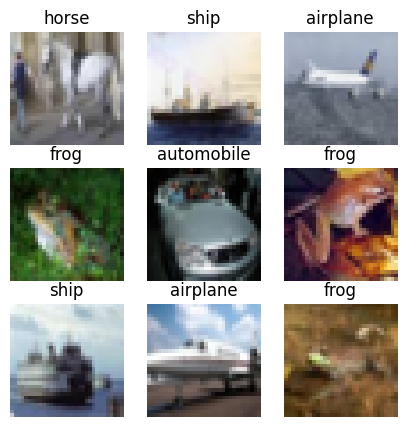

In [94]:
# Display some sample images from the MNIST dataset
plt.figure(figsize=(5, 5))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((x_train[i].squeeze() + 1.0) / 2.0)
    plt.title(classes[y_train[i].item()])
    plt.axis("off")


In [95]:
# Load pre-trained MobileNetV2 model
base_model = tf.keras.applications.MobileNetV3Large(
    alpha=1.0,
    include_top=False,  # Include classification layers
    weights='imagenet',  # Use pre-trained weights
    pooling='avg',
    include_preprocessing=False
)

base_model.trainable = False  # Freeze base model weights

# base_model.summary()

# Define model layers
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(10, activation='softmax')

# Data augmentation layers (currently disabled)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
])

# Build the model
inputs = tf.keras.Input(shape=(32, 32, 3))  # Original CIFAR10 image size
x = tf.keras.layers.Resizing(height=224, width=224)(inputs)  # Resize to match MobileNetV3
x = data_augmentation(x)  # Apply data augmentation
x = base_model(x, training=False)  # Pass through base model
x = tf.keras.layers.Dropout(0.2)(x)  # Add dropout for regularization
outputs = prediction_layer(x)  # Final classification layer

# Create the full model
model = tf.keras.Model(inputs, outputs)

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing (Resizing)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         9,610 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,005,962 (11.47 MB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [96]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="loss"),
    # Calculates how often predictions match integer labels
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [97]:
initial_epochs = 10

history = model.fit(x_train, y_train, epochs=initial_epochs, batch_size=128, validation_data=(x_dev, y_dev))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


313/313 ━━━━━━━━━━━━━━━━━━━━ 47s 130ms/step - accuracy: 0.4955 - loss: 1.4565 - val_accuracy: 0.8576 - val_loss: 0.4342
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7038 - loss: 0.8476 - val_accuracy: 0.8726 - val_loss: 0.3823
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7246 - loss: 0.7956 - val_accuracy: 0.8747 - val_loss: 0.3762
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.7319 - loss: 0.7619 - val_accuracy: 0.8751 - val_loss: 0.3720
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7395 - loss: 0.7494 - val_accuracy: 0.8819 - val_loss: 0.3517
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7425 - loss: 0.7363 - val_accuracy: 0.8803 - val_loss: 0.3526
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7499 - loss: 0.7192 - val_accuracy: 0.8826 - val_loss: 0.3506
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.7530 - loss: 0.7135 - val

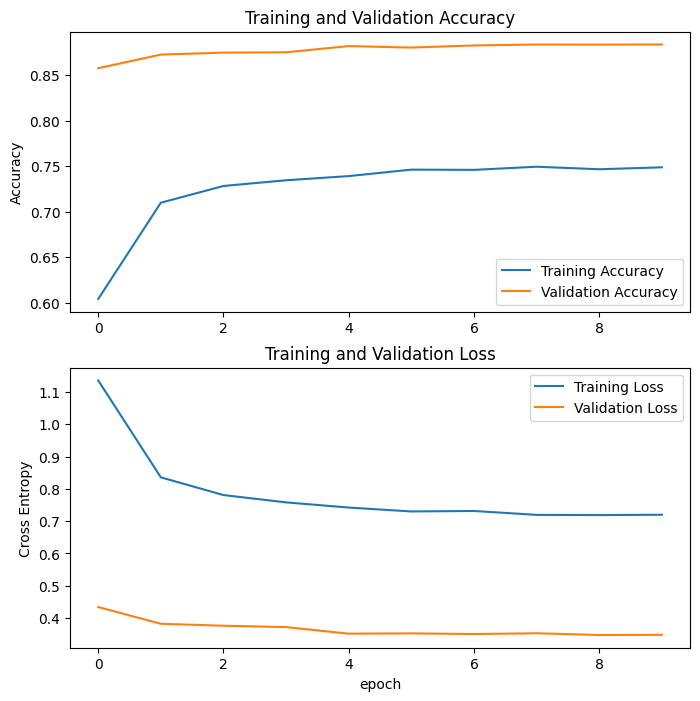

In [98]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [99]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", loss)
print("Test error:", (1 - accuracy)*100, "%")

313/313 - 5s - 17ms/step - accuracy: 0.8831 - loss: 0.3480
Test loss: 0.3479868471622467
Test error: 11.690002679824829 %


In [100]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  187


In [101]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.00001, weight_decay=0.0003),
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True, name="loss"),
    # Calculates how often predictions match integer labels
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
)

In [ ]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs


history_fine = model.fit(x_train, y_train, epochs=total_epochs,
                    initial_epoch=len(history.epoch), batch_size=128, validation_data=(x_dev, y_dev))

Epoch 11/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 96s 253ms/step - accuracy: 0.6383 - loss: 1.1458 - val_accuracy: 0.8855 - val_loss: 0.3428
Epoch 12/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.7505 - loss: 0.7266 - val_accuracy: 0.8970 - val_loss: 0.3108
Epoch 13/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.7803 - loss: 0.6419 - val_accuracy: 0.9067 - val_loss: 0.2849
Epoch 14/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.8007 - loss: 0.5693 - val_accuracy: 0.9110 - val_loss: 0.2669
Epoch 15/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.8155 - loss: 0.5344 - val_accuracy: 0.9135 - val_loss: 0.2543
Epoch 16/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.8232 - loss: 0.5035 - val_accuracy: 0.9151 - val_loss: 0.2464
Epoch 17/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 77s 245ms/step - accuracy: 0.8327 - loss: 0.4827 - val_accuracy: 0.9165 - val_loss: 0.2408
Epoch 18/30
313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - accuracy: 0.8412 -

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']


In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
# plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
# plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", loss)
print("Test error:", (1 - accuracy)*100, "%")

In [ ]:
model.save("my_model.keras")